# Linear Weighting Analysis

Given a cell with nodes $1,2$,
where the Gauss's Law solution would have $N1$ and $N2$ particles emitted.
Simple linear weight will give incorrect,
and Cartwright has this adjusted weighting:

\begin{eqnarray}
  N_{2w} = 2 N_2 - N_1 \\
  N_{1w} = 2 N_1 - N_2
\end{eqnarray}

This can be written in general as

\begin{eqnarray}
    N_{2w} = (a N_2 - N_1) / (a-1) \\
    N_{1w} = (a N_1 - N_2) / (a-1)
\end{eqnarray}

such that the number of particles in a cell ($1/2 (N_1+N_2)$) is independent of $a$.


With linear weighting, the particle distribution in the cell is

$$dQ(y) = N_{1w} (1-y) + N_{2w} (y)$$

and the total number of particles deposited at each gridpoint will be

$$Q_1 = \int_0^{1/2} dQ(y)$$

$$Q_2 = \int_{1/2}^{1} dQ(y)$$

when using NGP weighting.  If Gauss's Law is satisfied, then $Q_i = N_i/2$.

Since $dQ(y)$ is linear, these integrals are simply the area under each half of the trapezoid:

$$Q_1 = \frac{1}{ 4 } ( N_{1w} + 1/2 ( N_{1w} + N_{2w} ))$$

and if we plug the weights back in and expand, we get

$$
Q_1 = \frac{1}{ 4 (1-a) } ( (a N_1 - N_2 ) + 1/2 ( ( a N_1 - N_2) + (a N_2 - N_1 ))) = N_1 / 2 \\
3 (a N_1 - N_2) + (a N_2 - N_1) = 4 (a - 1) N_1 \\
(3a-1) N_1 + (a-3) N_2 = 4 (a-1) N_1
$$

Isolating $N_1,N_2$, we solve for $a$ in:

$$
\begin{align}
3 a - 1 = 4 (a-1)
(a-3) = 0
\end{align}
$$

The solution to both of which is $a=3$:

$$
(9-1) N_1 + (0) N_2 = 4 (3-1) N_1 \\
8 N_1 = 8 N_1 \\
\checkmark
$$

To confirm the error, plugging in $a=2$ gives

$$
\begin{align}
( 6 - 1) N_1 + (2-3) N_2 &= 4 (2-1) N_1 \\
&= 5 N_1 - N_2 \\
&= 4 N_1
\end{align}
$$

which will only be correct in the $N1=N2$ case (no gradient),
and which case is actually satisfied by *any* value of $a$.


In [1]:
%pylab inline

enabling inline matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
def do_ticks(dx):
    xlim(1-3.5*dx, 1+dx/2)
    xticks(1-(dx * np.linspace(0,3,4)),['K', 'n+1', 'n', 'n-1']) 
    ylim(99,102)
    yticks([])


In [3]:
def setup_dq(N=5, p=2, offset=100, color_index=0):
    """setup dQ with a number of points

    the profile is a constant, plus a polynomial wing,
    e.g. 100 + r^2
    """
    dx = 1./N
    dx2 = 0.5*dx
    r = linspace(0,1,N+1)
    r_fine = linspace(0,1,1000)
    dQ = offset + r**p
    dQ_fine = offset + r_fine**p

    plot(r,dQ,'ko')
    plot(r_fine,dQ_fine,'k', label="$dQ_n$")

    ax = gca()
    do_ticks(dx)
    rect = Rectangle((0, 0), 0, 0, label="$dQ'(x)$")
    ax.add_patch(rect)
    return dx, dx2, r, dQ

In [4]:
def adjust_weight(N1, N2, a=2.):
    """compute weighted N1,N2 with parameter

    N1w + N2w will always equal N1 + N2
    """
    N1w = (a * N1 - N2) / (a-1)
    N2w = (a * N2 - N1) / (a-1)
    return N1w, N2w

In [5]:
def integrate(N1w, N2w):
    """compute the total NGP-weighted dQ from trapezoid areas"""
    dQ2 = np.zeros(len(N1w)+1)
    # lefts are the trapezoid areas on the left (lower) side of each cell
    lefts = 0.5 * (N1w + 0.5 * (N1w + N2w))
    # rights are the trapezoid areas on the right (higher) side of each cell
    rights = 0.5 * (N2w + 0.5 * (N1w + N2w))
    # total dQ (NGP) at each node is the right side of the previous cell + the left side of the next
    dQ2[1:-1] = 0.5 * (rights[:-1] + lefts[1:])
    dQ2[0] = lefts[0]
    dQ2[-1] = rights[-1]
    return dQ2

In [6]:
def plot_trapezoids(r, N1w, N2w, n=4, color_index=0):
    """plot dQ trapezoid profile"""
    c = rcParams['axes.color_cycle'][color_index]

    N = len(N1w)
    ax = gca()
    for i in range(N-n,N):
        ax.fill_between([r[i],r[i+1]], 0, [N1w[i],N2w[i]])


Gauss Error: 0.18%


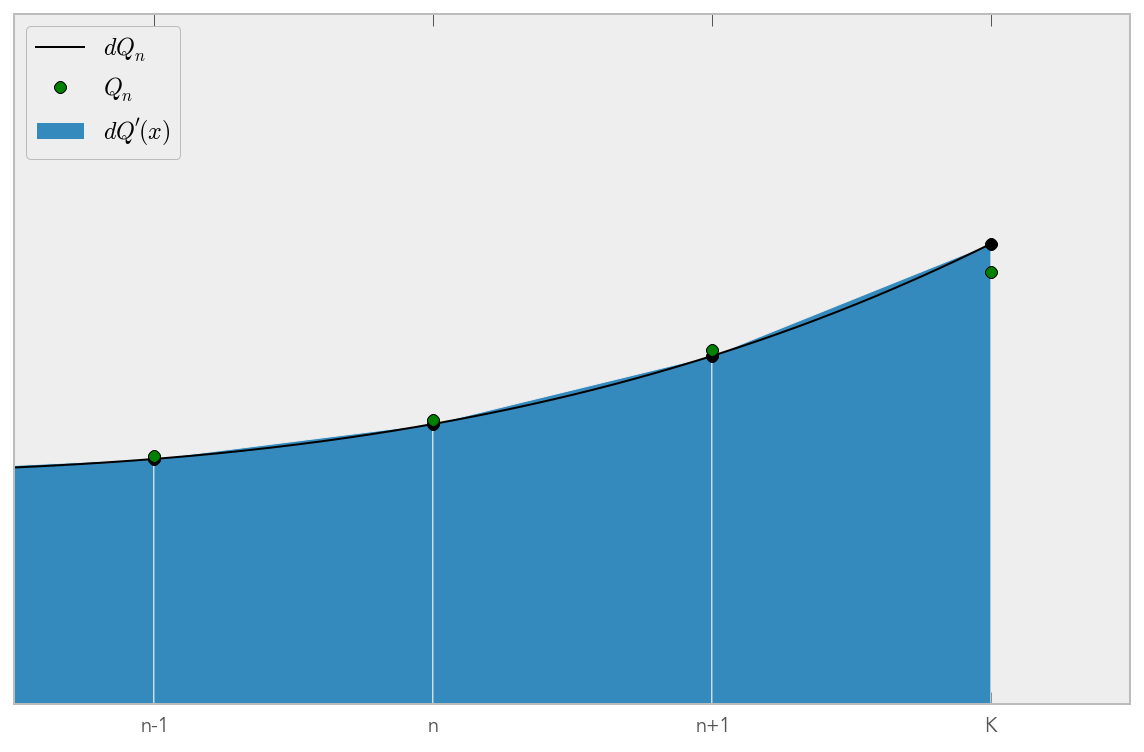

In [7]:
dx,dx2,r,dQ = setup_dq(N=5, p=3)
ax = gca()
N2 = dQ[1:]
N1 = dQ[:-1]

dQ1 = integrate(N1, N2)

deviation = 100 * abs(dQ1-dQ) / dQ
print "Gauss Error: %.2g%%" % sum(deviation)

plot_trapezoids(r, N1, N2)
plot(r, dQ1, 'go', label="$Q_n$")
plt.legend(loc="upper left")
# plt.title("Simple weighting ($N_{1w}=N_{1}$)");

Gauss Error: 0.18%


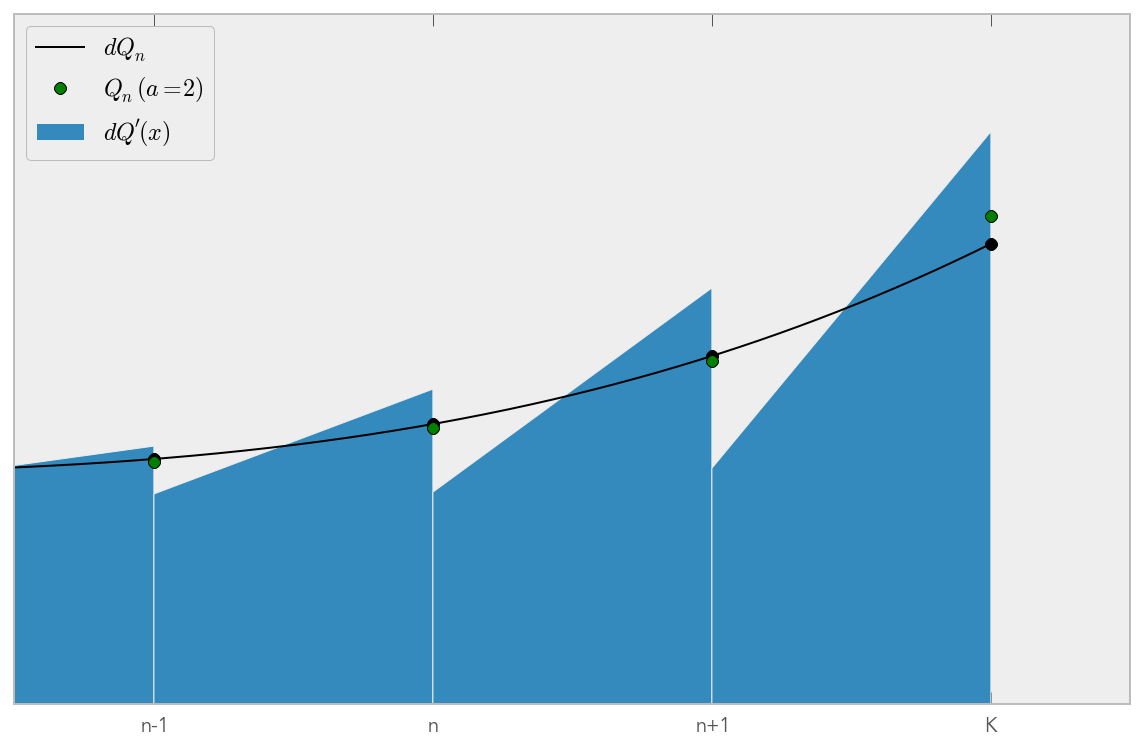

In [8]:
dx,dx2,r,dQ = setup_dq(N=5, p=3)
ax = gca()
N2 = dQ[1:]
N1 = dQ[:-1]
N1w, N2w = adjust_weight(N1, N2, 2)

dQ2 = integrate(N1w, N2w)
deviation = 100 * abs(dQ2-dQ) / dQ
print "Gauss Error: %.2g%%" % sum(deviation)
plot_trapezoids(r, N1w, N2w)
plot(r, dQ2, 'go', label="$Q_n(a=2)$")
legend(loc="upper left")
# plt.title("Cartwright weighting ($a=2$)");

Gauss Error: 2.8e-14%


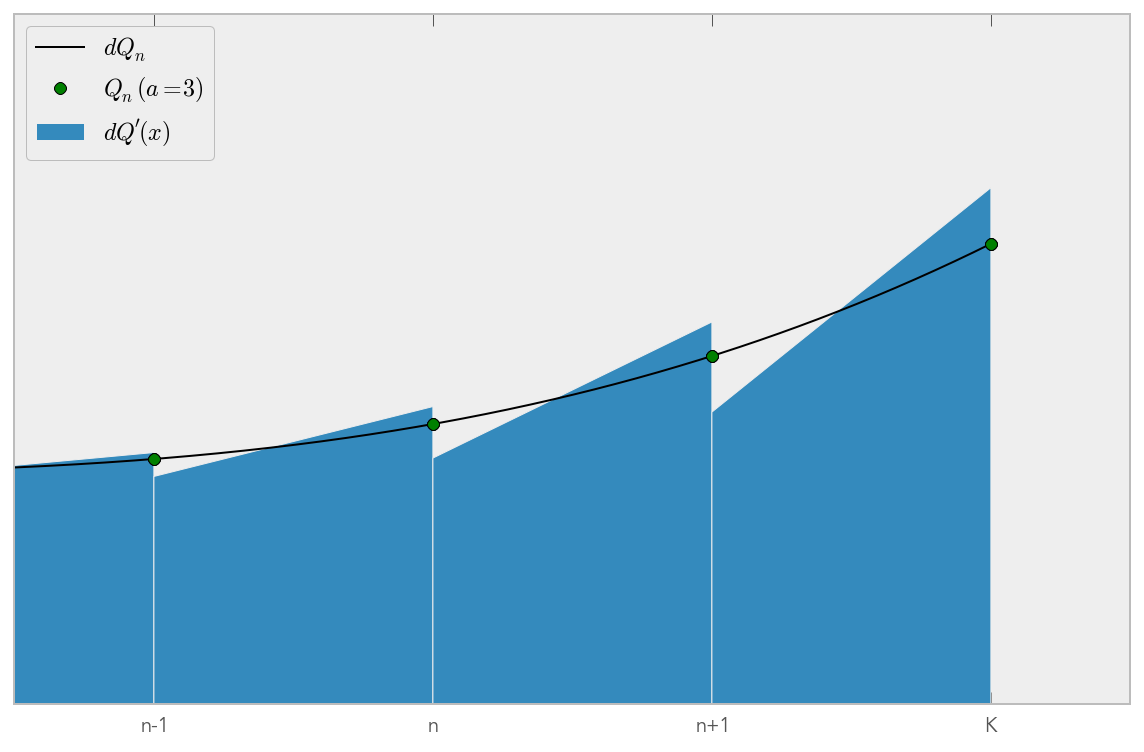

In [9]:
dx,dx2,r,dQ = setup_dq(N=5, p=3)
ax = gca()
N2 = dQ[1:]
N1 = dQ[:-1]
N1w, N2w = adjust_weight(N1, N2, 3)

dQ3 = integrate(N1w, N2w)
deviation = 100 * abs(dQ3-dQ) / dQ
print "Gauss Error: %.2g%%" % sum(deviation)
plot_trapezoids(r, N1w, N2w)

plot(r, dQ3, 'go', label="$Q_n(a=3)$")
# title("$a=3$ Weighting");
plt.legend(loc="upper left")


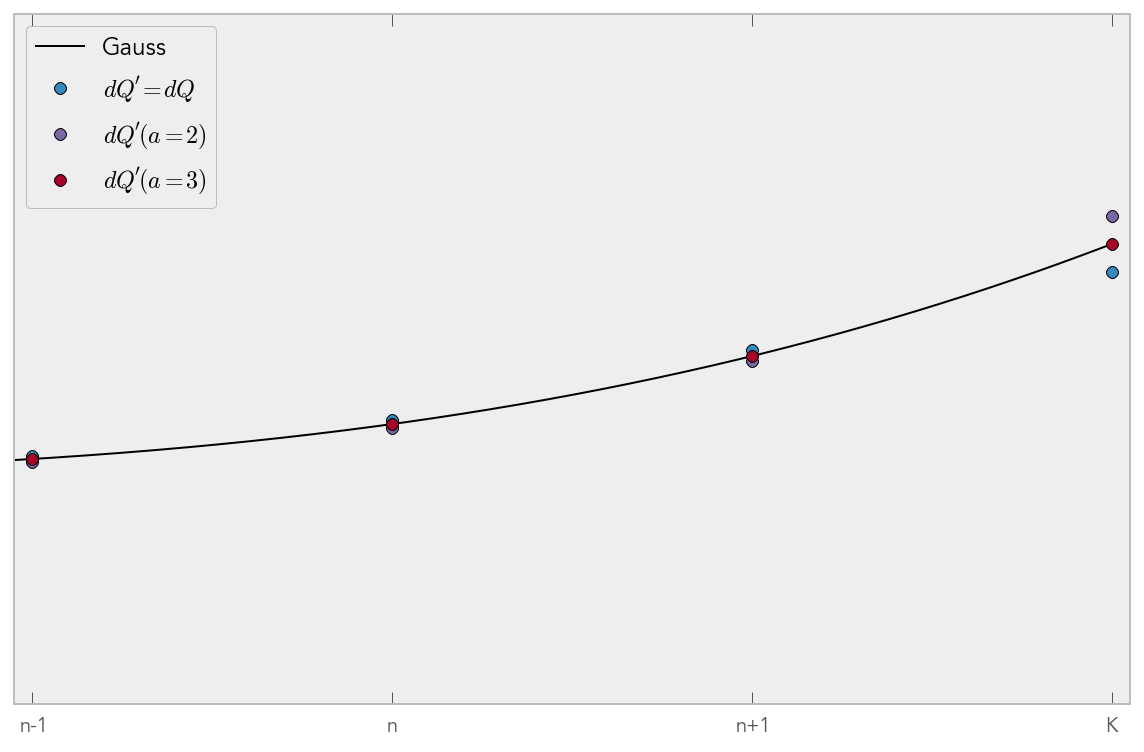

In [11]:
from scipy.interpolate import spline

r_fine = np.linspace(r.min(),r.max(),1000)
dQ_fine = spline(r,dQ,r_fine)

plot(r_fine, dQ_fine, 'k-', label="Gauss")
plot(r, dQ1, 'o', label="$dQ' = dQ$")
plot(r, dQ2, 'o', label="$dQ'(a=2)$")
plot(r, dQ3, 'o', label="$dQ'(a=3)$")
do_ticks(dx)
xlim(1-3*dx-.01,1.01)
legend(loc="upper left");

Which shows us that $a=3$ is precisely correct, while $a=2$ underestimates $dQ_n$ exactly the same amount as using the raw $N_i$ weights.
This shouldn't be surprising, since $a=3$ is the same as the average of $a=2$ and raw weights.

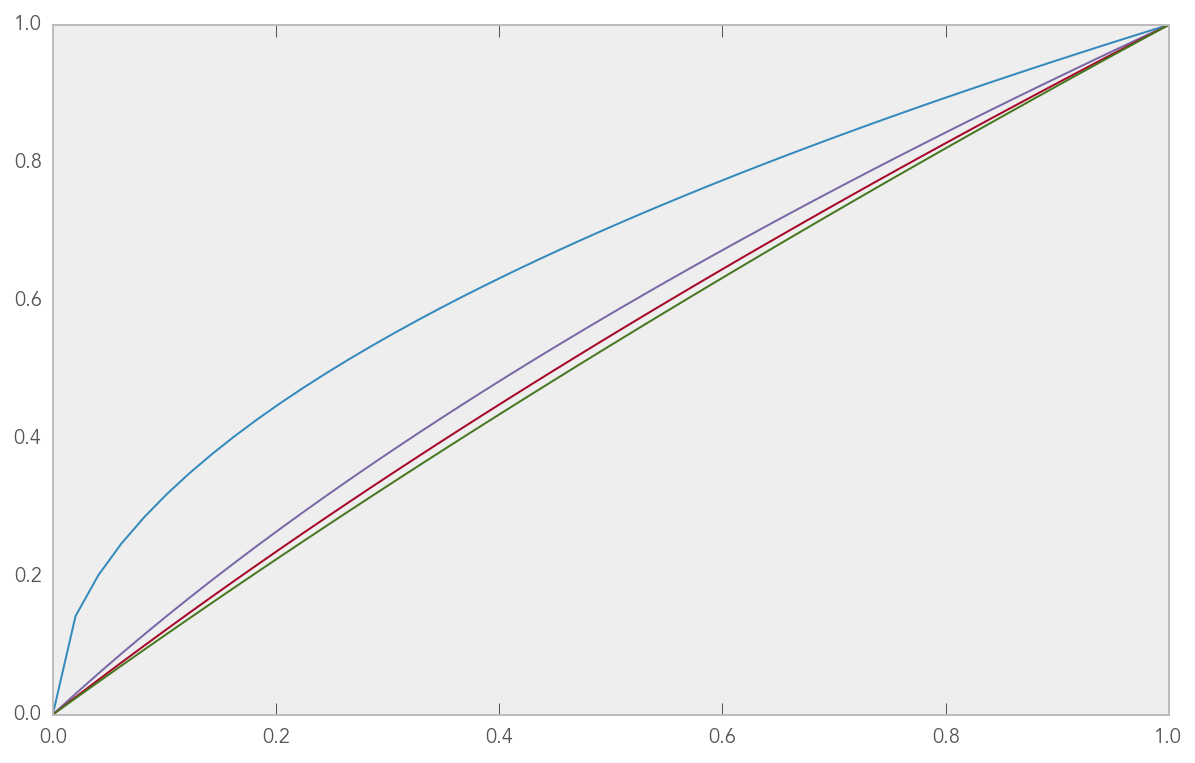

In [12]:
R = linspace(0,1)
for k in range(4):
    plot(R,sqrt(k*k + R*(2*k + 1))-k)